# Transformer Encoder-Decoder (Spanish Abstractive Article Summarization)

<img src= "https://drive.google.com/uc?export=view&id=1ShCt_EwSocA3oEqc-Hrqyzz3BqHCDMGH" width="60%" height="50%">

## Imports

In [56]:
## Imports 
## =============================================================================

# preprocessing
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Tensorflow API
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import Model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential, load_model
from keras.utils.vis_utils import plot_model
from tensorflow.keras import layers 
from tensorflow.keras.layers import Layer, Dense, Embedding, Dropout, MultiHeadAttention, LayerNormalization
from tensorflow.keras.initializers import Constant
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import LearningRateSchedule, ExponentialDecay
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler 

In [2]:
pip install https://github.com/explosion/spacy-models/releases/download/es_core_news_md-2.3.1/es_core_news_md-2.3.1.tar.gz --user

  Using cached wasabi-0.8.2-py3-none-any.whl (23 kB)
  Using cached blis-0.7.5-cp38-cp38-win_amd64.whl (6.6 MB)
  Using cached cymem-2.0.6-cp38-cp38-win_amd64.whl (36 kB)
  Using cached srsly-1.0.5-cp38-cp38-win_amd64.whl (178 kB)
  Using cached murmurhash-1.0.6-cp38-cp38-win_amd64.whl (21 kB)
  Using cached preshed-3.0.6-cp38-cp38-win_amd64.whl (113 kB)
Note: you may need to restart the kernel to use updated packages.


In [ ]:
pip install -q tensorflow-text

In [167]:
tf.__version__

'2.7.0'

In [168]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 1901741544008539118
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 4158062592
locality {
  bus_id: 1
  links {
  }
}
incarnation: 1074860223037010
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 2060 with Max-Q Design, pci bus id: 0000:01:00.0, compute capability: 7.5"
xla_global_id: 416903419
]


## Dataset Load

Dataset source: [MLSUM](https://github.com/huggingface/datasets/tree/master/datasets/mlsum), the first large-scale MultiLingual SUMmarization dataset. Obtained from online newspapers, it contains 1.5M+ article/summary pairs in five different languages: French, German, Spanish, Russian, Turkish. This work is just focused on the spanish articles.

In [ ]:
## Dataset load
## =============================================================================

df = pd.read_csv('es_train.txt', delimiter = "\t",  encoding = "ISO-8859-1")

In [ ]:
df.columns = ['url', 'pusblish date', 'article', 'summary', 'headline', 'category']

In [ ]:
print(df.shape)  # dimensions
print(df.size)   # size
df.head()        # first five elements

In [ ]:
## Original DAtaset copy
## =============================================================================
dataset = df.copy()

In [ ]:
# Missing data & data type
# ==============================================================================

# wrong data replacement 
dataset.replace("?", np.nan, inplace = True)

def missing_data(df):
    total   =  df.isnull().sum()
    percent = (df.isnull().sum().div(df.count())*100).round(3)
    df_missing_data = pd.DataFrame(({'NaN': total, '%': percent, 'types': df.dtypes}))
    return df_missing_data

In [ ]:
# missing data function application
missing_data(dataset)

In [ ]:
## Missing data strategy: Removing
## =============================================================================

categories = ['summary', 'headline', 'category']
dataset.dropna(subset=categories, inplace=True)

In [ ]:
# missing data function application
missing_data(dataset)

In [ ]:
print(f'Dataset elements: {dataset.shape[0]} \nDataset categories: {dataset.shape[1]}')

In [ ]:
# Unique values
# =============================================================================================================

categories = dataset['category'].unique()

text_df = pd.DataFrame({'category': dataset['category'].unique(),  'unique_values': (len(dataset.loc[dataset['category']== k]) for k in categories)}) \
  .sort_values('unique_values', ascending=False)

text_df    

In [ ]:
## Dataset plot
## =============================================================================

x = np.arange(len(categories))
width = 0.8

plt.figure(figsize=(18, 6))
plt.bar(x, text_df['unique_values'], width, color='green', label='Bookings')
plt.xticks(x, categories, rotation=90, fontsize=8)
plt.title('text categories')
plt.xlabel('categories')
plt.ylabel('count')
plt.xlim(-1,95);

## Split data (input, target)

In [ ]:
inputs_df, targets_df  = pd.DataFrame(), pd.DataFrame()

inputs_df['original'] = dataset['article']
targets_df['original'] = dataset['summary']


documents = inputs_df['original'].count()
summaries = targets_df['original'].count()

print(f'documents shape: {documents} \nsummaries shape: {summaries}')

## Clean text

In [ ]:
import spacy
from spacy.lang.es.examples import sentences
from spacy import displacy
spacy.prefer_gpu();

In [ ]:
nlp = spacy.load("es_core_news_md")

In [ ]:
from transformers import AutoModelForMaskedLM
from transformers import AutoTokenizer, FillMaskPipeline
from pprint import pprint

In [ ]:
tokenizer_hf = AutoTokenizer.from_pretrained('PlanTL-GOB-ES/roberta-base-bne')
model = AutoModelForMaskedLM.from_pretrained('PlanTL-GOB-ES/roberta-base-bne')
model.eval()

In [ ]:
pipeline = FillMaskPipeline(model, tokenizer_hf)
text = 'No tengo muchas <mask> de salir'
res_hf = pipeline(text)
pprint([r['sequence'] for r in res_hf])

The preprocessing step for this case will be quite simple as the maximum information is needed for a comprehensive undersanting on a text generation task. It'll be just dismissed unusual symbols and added the target decoder-sequence: `<go> text <stop>` .

In [ ]:
## Tokenizing by word and removing any ususual symbol
## decoder sequence <go> text <stop>
## =============================================================================

def clean_text(text, target):
    doc=nlp(text)
    clean_text_list = [token.text.lower() for token in doc if token.pos_ not in ['SYM', 'X']]
    if target:
        clean_text_list.insert(0, '<go>')
        clean_text_list.append('<stop>')
    return clean_text_list

In [ ]:
inputs_df['clean_words']  = inputs_df['original'].apply(lambda x: clean_text(x, target = False))
targets_df['clean_words'] = targets_df['original'].apply(lambda x: clean_text(x, target = True))

In [ ]:
## Text length
## =============================================================================

inputs_df['length'] =  inputs_df['clean_words'].apply(lambda x: len(x))
targets_df['length'] = targets_df['clean_words'].apply(lambda x: len(x))

In [ ]:
# Histograms
# ==============================================================================

import matplotlib.pyplot as plt
import seaborn as sns

n_bins = 50

plt.figure(figsize=(15, 5))
sns.set_style("darkgrid")

plt.subplot(121)
sns.histplot(data=inputs_df['length'], bins=n_bins, color="#3182bd", kde=True)
plt.title('documents word length histogram')
plt.xlabel('count')
plt.ylabel('documents')

plt.subplot(122)
sns.histplot(data=targets_df['length'], bins=n_bins, color="#3182bd", kde=True)
plt.title('summaries word length histogram')
plt.xlabel('count')
plt.ylabel('summaries')

plt.subplots_adjust(wspace=0.2, hspace=0.3);

In [ ]:
## Max length calculation input/target
## =============================================================================

def max_length(longs, shorts, prct):
    # Create a list of all the captions
    
    prct_longs =  np.percentile(longs, prct)
    prct_shorts = np.percentile(shorts, prct)

    print(f'percentile {prct}% of length of documents: {prct_longs:0.0f} words')
    print(f'longest sentence: {longs.max()} words \n')

    print(f'percentile {prct}% of length of summaries: {prct_shorts:0.0f} words')
    print(f'longest sentence: {shorts.max()} words \n')

    return prct_longs, prct_shorts

# selecting sentence length based on the percentile of data that fits in the length
input_maxlen, target_maxlen = max_length(inputs_df['length'], targets_df['length'], 90)

print(f'max-length documents chosen for training: {input_maxlen:0.0f}')
print(f'max-length summaries chosen for training: {target_maxlen:0.0f}')

## Copy

In [ ]:
## save numpy arrays
## =============================================================================

np.save('inputs.npy', inputs_df['clean_words'].values)
np.save('targets.npy', targets_df['clean_words'].values)

In [2]:
## load numpy array
## =============================================================================

inputs =  np.load('inputs.npy', allow_pickle='TRUE')
targets = np.load('targets.npy', allow_pickle='TRUE')

In [3]:
df = pd.DataFrame({'inputs': inputs, 'targets': targets})

In [4]:
## Shorten dataset
## =============================================================================

df_short = df[(df['inputs'].map(len) <= 512) & (df['targets'].map(len) <= 40) ].reset_index()
print(df_short['inputs'].map(len).max())
print(df_short['targets'].map(len).max())

512
40


## Split Train/Test (90/10)

In [5]:
## Split dataset
## =============================================================================

# Imports
from sklearn.model_selection import train_test_split

# split X/y
X = df_short['inputs']
y = df_short['targets']

# train dataset 90% test dataset 10%
X_train_text, X_test_text, y_train_text, y_test_text = train_test_split(X, y, test_size=0.05, random_state=32)

print(f'train dataset shape: {X_train_text.shape[0]} documents \ntest dataset shape: {X_test_text.shape[0]} documents')

train dataset shape: 20622 documents 
test dataset shape: 1086 documents


In [6]:
X_train_text.reset_index(drop=True, inplace=True)
y_train_text.reset_index(drop=True, inplace=True)

X_test_text.reset_index(drop=True, inplace=True)
y_test_text.reset_index(drop=True, inplace=True)

## Tokennizing

In [8]:
## Keras tokenizer instance
## =============================================================================

oov_token = '<UNK>'
input_tokenizer = Tokenizer(oov_token=oov_token)
target_tokenizer = Tokenizer(oov_token=oov_token)

In [9]:
## Train dataset tokenizing
## =============================================================================

input_tokenizer.fit_on_texts(X_train_text)
target_tokenizer.fit_on_texts(y_train_text)

In [10]:
## Training vocabulary
## =============================================================================

input_tokenizer.word_index['<PAD0>'] = 0
target_tokenizer.word_index['<PAD0>'] = 0

X_train_vocab_size = len(input_tokenizer.word_index) + 1
y_train_vocab_size = len(target_tokenizer.word_index) + 1

# vocab_size
print(f'iputs vocabulary size: {X_train_vocab_size} words \ntargets vocabulary size: {y_train_vocab_size} words')

iputs vocabulary size: 175365 words 
targets vocabulary size: 38152 words


In [11]:
## input/target index_word dictionary
## =============================================================================

input_index_word = dict(zip(input_tokenizer.word_index.values(), input_tokenizer.word_index.keys()))
target_index_word = dict(zip(target_tokenizer.word_index.values(), target_tokenizer.word_index.keys()))

In [12]:
## save numpy dics
## =============================================================================

np.save('input_index_word.npy', input_index_word)
np.save('target_index_word.npy', target_index_word)

In [13]:
## from token to numbers train dataset
## =============================================================================

X_train_num = input_tokenizer.texts_to_sequences(X_train_text)
y_train_num = target_tokenizer.texts_to_sequences(y_train_text)

Test dataset preparing

In [14]:
## from token to numbers USING TRANSFORM ON TRAINING DATASET
## =============================================================================

X_test_num = input_tokenizer.texts_to_sequences(X_test_text)
y_test_num = target_tokenizer.texts_to_sequences(y_test_text)

## Padding/Truncating sequences for identical sequence lengths

In [15]:
input_maxlen=512
target_maxlen=40

In [16]:
## Train Dataset
## =============================================================================
X_train_num = pad_sequences(X_train_num, maxlen=input_maxlen, padding='post', truncating='post') 
y_train_num = pad_sequences(y_train_num, maxlen=target_maxlen, padding='post', truncating='post')

# Test Dataset
X_test_num = pad_sequences(X_test_num, maxlen=input_maxlen, padding='post', truncating='post')
y_test_num = pad_sequences(y_test_num, maxlen=target_maxlen, padding='post', truncating='post')

In [17]:
## Train Dataset (casting)
## =============================================================================
X_train_num = tf.cast(X_train_num, dtype=tf.int32)
y_train_num = tf.cast(y_train_num, dtype=tf.int32)

## Teset Dataset (casting)
## =============================================================================
X_test_num = tf.cast(X_test_num, dtype=tf.int32)
y_teset_num = tf.cast(y_test_num, dtype=tf.int32)

## Dataset Generator

In [18]:
## batch_size
## =============================================================================

BATCH_SIZE = 8

In [19]:
## train/tes_dataset
## =============================================================================

train_ds = tf.data.Dataset.from_tensor_slices((X_train_num, y_train_num)).batch(BATCH_SIZE)
test_ds = tf.data.Dataset.from_tensor_slices((X_test_num, y_test_num)).batch(BATCH_SIZE)

In [20]:
for input, target in test_ds.take(1):
    print(f'inputs shape: {input.shape}')
    print(f'targets shape: {target.shape}')

inputs shape: (8, 512)
targets shape: (8, 40)


In [21]:
## save datasets
## =============================================================================

tf.data.experimental.save(train_ds, os.path.join('train_ds'), compression=None, shard_func=None)
tf.data.experimental.save(test_ds, os.path.join('test_ds'), compression=None, shard_func=None)

## Embedding training

In [ ]:
## embedding dimension
## =============================================================================

embedding_dim = 300

In [ ]:
embedding_ds = pd.concat([X_train_text, y_train_text]).reset_index(drop=True)
len(embedding_ds)

In [ ]:
## embedding training input/target
## =============================================================================

from gensim.models import Word2Vec

#input_model =  Word2Vec(X_train_text, vector_size=embedding_dim, window=5, min_count=1, workers=4)
#target_model = Word2Vec(y_train_text, vector_size=embedding_dim, window=5, min_count=1, workers=4)
embedding =  Word2Vec(embedding_ds, vector_size=embedding_dim, window=5, min_count=1, workers=4)

In [ ]:
#input_word_vecs = input_model.wv
#target_word_vecs = target_model.wv
word_vecs = embedding.wv

In [ ]:
#print (f'input vocabulary size: {len(input_word_vecs.key_to_index.keys())+1} words \ntarget vocabulary size: {len(target_word_vecs.key_to_index.keys())+1} words \nembedding dimension: {input_word_vecs.vector_size}')

print (f'input vocabulary size: {len(word_vecs.key_to_index.keys())+1}')

In [ ]:
## similar words example
## =============================================================================

word_vecs.most_similar('película')

embeddings save

In [ ]:
## embeddings paths
## =============================================================================

# input_embeddings_path = 'input_custom_w2v.txt'
# target_embeddings_path = 'target_custom_w2v.txt'
embeddings_path = 'custom_w2v.txt'

In [ ]:
## save embeddings
## =============================================================================

#input_word_vecs.save_word2vec_format(input_embeddings_path, binary=False)
#target_word_vecs.save_word2vec_format(target_embeddings_path, binary=False)
word_vecs.save_word2vec_format(embeddings_path, binary=False)

### Embedding Matrix input/target

In [ ]:
def embeddings_index(embeddings_path):
    embeddings_index = {}
    with open(embeddings_path, encoding='utf-8') as f:
        for line in f:
            word, coefs = line.split(maxsplit=1)
            coefs = np.fromstring(coefs, "f", sep=" ")
            embeddings_index[word] = coefs

    print("Found %s word vectors." % len(embeddings_index))
    return embeddings_index

In [ ]:
def embedding_matrix (num_tokens, word_index, embedding_dim, embeddings_index):
    hits = 1
    misses = []
    embedding_matrix = np.zeros((num_tokens, embedding_dim))
    for word, i in word_index.items():
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            # Words not found in embedding index will be all-zeros.
            # This includes the representation for "padding" and "OOV"
            embedding_matrix[i] = embedding_vector
            hits += 1
        else:
            misses.append(word)
    print("Converted %d words (%d misses)" % (hits, len(misses)))
    return embedding_matrix, misses

In [ ]:
## embedding matrix input
## =============================================================================

#input_embeddings_index = embeddings_index(input_embeddings_path)
#input_embedding_matrix, input_misses = embedding_matrix(X_train_vocab_size, input_tokenizer.word_index, embedding_dim, input_embeddings_index)

input_embeddings_index = embeddings_index(embeddings_path)
input_embedding_matrix, input_misses = embedding_matrix(X_train_vocab_size, input_tokenizer.word_index, embedding_dim, input_embeddings_index)

In [ ]:
## embedding matrix target
## =============================================================================

#target_embeddings_index = embeddings_index(target_embeddings_path)
#target_embedding_matrix, misses = embedding_matrix(y_train_vocab_size, target_tokenizer.word_index, embedding_dim, target_embeddings_index)

target_embeddings_index = embeddings_index(embeddings_path)
target_embedding_matrix, misses = embedding_matrix(y_train_vocab_size, target_tokenizer.word_index, embedding_dim, target_embeddings_index)

In [ ]:
## save embedding matrix input/target
## =============================================================================

np.save('input_embedding_matrix.npy', input_embedding_matrix)
np.save('target_embedding_matrix.npy', target_embedding_matrix)

## Model Build

Model source: [Transformer model for language understanding
](https://www.tensorflow.org/text/tutorials/transformer). This code propossed by Tensorflow team reflects the essence of the original transformer paper based on a encoder-decoder transformer architecture 

## Transformer Encoder-Decoder (Multi-Headed Attention)

<img src= "https://drive.google.com/uc?export=view&id=1b-udy2L-hBXc8vRY-5wwtrBEEnPMHVME" width="50%" height="50%">

### Load data

In [22]:
## load numpy index dictionary
## =============================================================================

input_index_word =  np.load('input_index_word.npy', allow_pickle='TRUE')
target_index_word =  np.load('target_index_word.npy', allow_pickle='TRUE')

In [23]:
## load embedding matrix input/target
## =============================================================================

input_embedding_matrix=np.load('input_embedding_matrix.npy')
target_embedding_matrix=np.load('target_embedding_matrix.npy')

print(f'input_embedding_matrix shape: {input_embedding_matrix.shape} \ntarget_embedding_matrix shape: {target_embedding_matrix.shape}')

input_embedding_matrix shape: (175365, 300) 
target_embedding_matrix shape: (38152, 300)


In [24]:
## load datasets train/test
## =============================================================================

train_ds = tf.data.experimental.load('train_ds')
test_ds = tf.data.experimental.load('test_ds')

In [25]:
for input, target in test_ds.take(1):
    print(f'inputs shape: {input.shape}')
    print(f'targets shape: {target.shape}')

inputs shape: (8, 512)
targets shape: (8, 40)


## Transformer architecture

### Positional Encoding

In [26]:
def get_angles(pos, i, d_model):
    angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(d_model))
    return pos * angle_rates

def positional_encoding(position, d_model):
    angle_rads = get_angles(np.arange(position)[:, np.newaxis],
                          np.arange(d_model)[np.newaxis, :],
                          d_model)

    # apply sin to even indices in the array; 2i
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])

    # apply cos to odd indices in the array; 2i+1
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])

    pos_encoding = angle_rads[np.newaxis, ...]

    return tf.cast(pos_encoding, dtype=tf.float32)

### Masking

In [27]:
def create_padding_mask(seq):
    seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
    return seq[:, tf.newaxis, tf.newaxis, :]  

### LookAhead Mask

In [28]:
def create_look_ahead_mask(size):
    mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
    return mask  

### Scalar Dot Product

In [29]:
def scaled_dot_product_attention(q, k, v, mask):
    matmul_qk = tf.matmul(q, k, transpose_b=True) 
    
    dk = tf.cast(tf.shape(k)[-1], tf.float32)
    scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)

    if mask is not None:
        scaled_attention_logits += (mask * -1e9)
        
    attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)  
    output = tf.matmul(attention_weights, v)

    return output, attention_weights

### MultiHead Attention

In [30]:
class MultiHeadAttention(Layer):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model

        assert d_model % self.num_heads == 0

        self.depth = d_model // self.num_heads

        self.wq = Dense(d_model, kernel_regularizer=l2(lmbda_l2))
        self.wk = Dense(d_model, kernel_regularizer=l2(lmbda_l2))
        self.wv = Dense(d_model, kernel_regularizer=l2(lmbda_l2))

        self.dense = Dense(d_model)

    def split_heads(self, x, batch_size):
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(x, perm=[0, 2, 1, 3])

    def call(self, v, k, q, mask):
        batch_size = tf.shape(q)[0]

        q = self.wq(q)  
        k = self.wk(k) 
        v = self.wv(v)  

        q = self.split_heads(q, batch_size) 
        k = self.split_heads(k, batch_size) 
        v = self.split_heads(v, batch_size)  

        scaled_attention, attention_weights = scaled_dot_product_attention(
            q, k, v, mask)

        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3]) 

        concat_attention = tf.reshape(scaled_attention,
                                      (batch_size, -1, self.d_model)) 

        output = self.dense(concat_attention) 

        return output, attention_weights

### Point Wise

In [31]:
def point_wise_feed_forward_network(d_model, dff):
    return tf.keras.Sequential([
        Dense(dff, activation='relu'),  # (batch_size, seq_len, dff)
        Dense(d_model)  # (batch_size, seq_len, d_model)
  ])

## Encoder Decoder

### Encoder Layer

In [32]:
class EncoderLayer(Layer):
    def __init__(self, d_model, num_heads, dff, rate=0.1):
        super(EncoderLayer, self).__init__()

        self.mha = MultiHeadAttention(d_model, num_heads)
        self.ffn = point_wise_feed_forward_network(d_model, dff)

        self.layernorm1 = LayerNormalization(epsilon=1e-6)
        self.layernorm2 = LayerNormalization(epsilon=1e-6)

        self.dropout1 = Dropout(rate)
        self.dropout2 = Dropout(rate)

    def call(self, x, training, mask):

        attn_output, _ = self.mha(x, x, x, mask)  # (batch_size, input_seq_len, d_model)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(x + attn_output)  # (batch_size, input_seq_len, d_model)

        ffn_output = self.ffn(out1)  # (batch_size, input_seq_len, d_model)
        ffn_output = self.dropout2(ffn_output, training=training)
        out2 = self.layernorm2(out1 + ffn_output)  # (batch_size, input_seq_len, d_model)

        return out2

### Decoder Layer

In [33]:
class DecoderLayer(Layer):
    def __init__(self, d_model, num_heads, dff, dropout_rate):
        super(DecoderLayer, self).__init__()

        self.mha1 = MultiHeadAttention(d_model, num_heads)
        self.mha2 = MultiHeadAttention(d_model, num_heads)

        self.ffn = point_wise_feed_forward_network(d_model, dff)

        self.layernorm1 = LayerNormalization(epsilon=1e-6)
        self.layernorm2 = LayerNormalization(epsilon=1e-6)
        self.layernorm3 = LayerNormalization(epsilon=1e-6)

        self.dropout1 = Dropout(dropout_rate)
        self.dropout2 = Dropout(dropout_rate)
        self.dropout3 = Dropout(dropout_rate)

    def call(self, x, enc_output, training,
           look_ahead_mask, padding_mask):
        # enc_output.shape == (batch_size, input_seq_len, d_model)

        attn1, attn_weights_block1 = self.mha1(x, x, x, look_ahead_mask)  # (batch_size, target_seq_len, d_model)
        attn1 = self.dropout1(attn1, training=training)
        out1 = self.layernorm1(attn1 + x)

        attn2, attn_weights_block2 = self.mha2(
            enc_output, enc_output, out1, padding_mask)  # (batch_size, target_seq_len, d_model)
        attn2 = self.dropout2(attn2, training=training)
        out2 = self.layernorm2(attn2 + out1)  # (batch_size, target_seq_len, d_model)

        ffn_output = self.ffn(out2)  # (batch_size, target_seq_len, d_model)
        ffn_output = self.dropout3(ffn_output, training=training)
        out3 = self.layernorm3(ffn_output + out2)  # (batch_size, target_seq_len, d_model)

        return out3, attn_weights_block1, attn_weights_block2

### Encoder

In [34]:
class Encoder(Layer):
    def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size,
               maximum_position_encoding, dropout_rate):
        super(Encoder, self).__init__()

        self.d_model = d_model
        
        self.num_layers = num_layers
        
        self.embedding = Embedding(input_dim=input_vocab_size, 
                                    output_dim=d_model,
                                    embeddings_initializer=Constant(input_embedding_matrix),
                                    trainable=False
                                  )
        self.pos_encoding = positional_encoding(maximum_position_encoding,
                                                self.d_model)

        self.enc_layers = [EncoderLayer(d_model, num_heads, dff, dropout_rate)
                           for _ in range(num_layers)]

        self.dropout = Dropout(dropout_rate)

    def call(self, x, training, mask):

        seq_len = tf.shape(x)[1]

        # adding embedding and position encoding.
        x = self.embedding(x)  # (batch_size, input_seq_len, d_model)
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x += self.pos_encoding[:, :seq_len, :]

        x = self.dropout(x, training=training)

        for i in range(self.num_layers):
            x = self.enc_layers[i](x, training, mask)

        return x  # (batch_size, input_seq_len, d_model)

### Decoder

In [35]:
class Decoder(Layer):
    def __init__(self, num_layers, d_model, num_heads, dff, target_vocab_size,
                   maximum_position_encoding, dropout_rate):
        super(Decoder, self).__init__()

        self.d_model = d_model
        
        self.num_layers = num_layers

        self.embedding = Embedding(input_dim=target_vocab_size, 
                output_dim=d_model,
                embeddings_initializer=Constant(target_embedding_matrix),
                trainable=False)
        
        self.pos_encoding = positional_encoding(maximum_position_encoding, d_model)

        self.dec_layers = [DecoderLayer(d_model, num_heads, dff, dropout_rate)
                           for _ in range(num_layers)]
        self.dropout = Dropout(dropout_rate)

    def call(self, x, enc_output, training,
               look_ahead_mask, padding_mask):

        seq_len = tf.shape(x)[1]
        attention_weights = {}

        x = self.embedding(x)  # (batch_size, target_seq_len, d_model)
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x += self.pos_encoding[:, :seq_len, :]

        x = self.dropout(x, training=training)

        for i in range(self.num_layers):
            x, block1, block2 = self.dec_layers[i](x, enc_output, training,
                                                 look_ahead_mask, padding_mask)

            attention_weights[f'decoder_layer{i+1}_block1'] = block1
            attention_weights[f'decoder_layer{i+1}_block2'] = block2

        # x.shape == (batch_size, target_seq_len, d_model)
        return x, attention_weights

### Transformer

In [36]:
class Transformer(Model):
    def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size,
                   target_vocab_size, pe_input, pe_target, dropout_rate):
        super().__init__()
        self.encoder = Encoder(num_layers, d_model, num_heads, dff,
                                 input_vocab_size, pe_input, dropout_rate)

        self.decoder = Decoder(num_layers, d_model, num_heads, dff,
                               target_vocab_size, pe_target, dropout_rate)

        self.final_layer = Dense(target_vocab_size)

    def call(self, inputs, training):
        # Keras models prefer if you pass all your inputs in the first argument
        inp, tar = inputs

        enc_padding_mask, look_ahead_mask, dec_padding_mask = self.create_masks(inp, tar)

        enc_output = self.encoder(inp, training, enc_padding_mask)  # (batch_size, inp_seq_len, d_model)

        # dec_output.shape == (batch_size, tar_seq_len, d_model)
        dec_output, attention_weights = self.decoder(
            tar, enc_output, training, look_ahead_mask, dec_padding_mask)

        final_output = self.final_layer(dec_output)  # (batch_size, tar_seq_len, target_vocab_size)

        return final_output, attention_weights

    def create_masks(self, inp, tar):
        # Encoder padding mask
        enc_padding_mask = create_padding_mask(inp)

        # Used in the 2nd attention block in the decoder.
        # This padding mask is used to mask the encoder outputs.
        dec_padding_mask = create_padding_mask(inp)

        # Used in the 1st attention block in the decoder.
        # It is used to pad and mask future tokens in the input received by
        # the decoder.
        look_ahead_mask = create_look_ahead_mask(tf.shape(tar)[1])
        dec_target_padding_mask = create_padding_mask(tar)
        look_ahead_mask = tf.maximum(dec_target_padding_mask, look_ahead_mask)

        return enc_padding_mask, look_ahead_mask, dec_padding_mask

### Learning Rate

In [37]:
# lr_schedule = ExponentialDecay(
#     initial_learning_rate=1e-5, 
#     decay_steps=4000, 
#     decay_rate=0.9) 

optimizer = tf.keras.optimizers.Adagrad(
    learning_rate=0.001,
    initial_accumulator_value=0.1,
    epsilon=1e-07,
    name="Adagrad"
)

### Loss definition

In [38]:
loss_object = SparseCategoricalCrossentropy(from_logits=True, reduction='none')

In [39]:
def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_sum(loss_)/tf.reduce_sum(mask)

In [40]:
train_loss = tf.keras.metrics.Mean(name='train_loss')

### Hyperparameters

In [41]:
## Hyperparams
## ========================================================

lmbda_l2   = 0.1
num_layers = 5           # chaged from 4 to 5 to learn better
d_model    = 300         # d_model is the representation dimension or embedding dimension of a word (usually in the range 128–512)
dff        = 2048        # number of neurons in feed forward network
num_heads  = 12          
rate       = 0.1

### Transformer Model

In [42]:
transformer = Transformer(
    num_layers=num_layers,
    d_model=d_model,
    num_heads=num_heads,
    dff=dff,
    input_vocab_size= input_embedding_matrix.shape[0],
    target_vocab_size=target_embedding_matrix.shape[0],
    pe_input=512,
    pe_target=40,
    dropout_rate=rate)

## Training

### Checkpoints

In [43]:
checkpoint_path = "./checkpoints_2"

ckpt = tf.train.Checkpoint(transformer=transformer,
                           optimizer=optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

# if a checkpoint exists, restore the latest checkpoint.
if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print('Latest checkpoint restored!!')

Latest checkpoint restored!!


In [170]:
EPOCHS = 30

Train

In [172]:
train_step_signature = [
    tf.TensorSpec(shape=(None, None), dtype=tf.int32),
    tf.TensorSpec(shape=(None, None), dtype=tf.int32),
]


@tf.function(input_signature=train_step_signature)
def train_step(inp, tar):
    tar_inp = tar[:, :-1]
    tar_real = tar[:, 1:]
    
    with tf.GradientTape() as tape:
        predictions, _ = transformer([inp, tar_inp],
                                    training = True,)
        loss = loss_function(tar_real, predictions)

    gradients = tape.gradient(loss, transformer.trainable_variables)
    optimizer.apply_gradients(zip(gradients, transformer.trainable_variables))

    train_loss(loss)

In [173]:
import time

for epoch in range(EPOCHS):
    start = time.time()

    train_loss.reset_states()

    # inp -> articles, tar -> summaries
    for (batch, (inp, tar)) in enumerate(train_ds):
        train_step(inp, tar)

        if batch % 200 == 0:
            print(f'Epoch {epoch + 1} Batch {batch} Loss {train_loss.result():.4f}')

ckpt_save_path = ckpt_manager.save()
print(f'Epoch {epoch + 1} Loss {train_loss.result():.4f}')
print(f'Time taken for {batch} batches: {time.time() - start:.2f} secs\n')

Epoch 1 Batch 0 Loss 1.6117
Epoch 1 Batch 200 Loss 1.5734
Epoch 1 Batch 400 Loss 1.5700
Epoch 1 Batch 600 Loss 1.5650
Epoch 1 Batch 800 Loss 1.5631
Epoch 1 Batch 1000 Loss 1.5708
Epoch 1 Batch 1200 Loss 1.5715
Epoch 1 Batch 1400 Loss 1.5783
Epoch 1 Batch 1600 Loss 1.5765
Epoch 1 Batch 1800 Loss 1.5757
Epoch 1 Batch 2000 Loss 1.5764
Epoch 1 Batch 2200 Loss 1.5769
Epoch 1 Batch 2400 Loss 1.5756
Epoch 2 Batch 0 Loss 1.6522
Epoch 2 Batch 200 Loss 1.5734
Epoch 2 Batch 400 Loss 1.5746
Epoch 2 Batch 600 Loss 1.5711
Epoch 2 Batch 800 Loss 1.5682
Epoch 2 Batch 1000 Loss 1.5730
Epoch 2 Batch 1200 Loss 1.5738
Epoch 2 Batch 1400 Loss 1.5796
Epoch 2 Batch 1600 Loss 1.5775
Epoch 2 Batch 1800 Loss 1.5758
Epoch 2 Batch 2000 Loss 1.5768
Epoch 2 Batch 2200 Loss 1.5765
Epoch 2 Batch 2400 Loss 1.5756
Epoch 3 Batch 0 Loss 1.6796
Epoch 3 Batch 200 Loss 1.5789
Epoch 3 Batch 400 Loss 1.5740
Epoch 3 Batch 600 Loss 1.5694
Epoch 3 Batch 800 Loss 1.5665
Epoch 3 Batch 1000 Loss 1.5712
Epoch 3 Batch 1200 Loss 1.571

## Validation

In [44]:
## parameters
## =============================================================================

max_decoded_sentence_length = 40
target_index_lookup = target_index_word

In [45]:
def decode_sequence(input_sentence):
    
    tokenized_input_sentence = input_tokenizer.texts_to_sequences([input_sentence])
    tokenized_input_sentence = tf.expand_dims(tokenized_input_sentence[0], 0)
    
    decoded_sentence = [target_tokenizer.word_index["<go>"]]
    decoded_sentence = tf.expand_dims(decoded_sentence, 0)
    
    for i in range(max_decoded_sentence_length):
        predictions, attention_weights = transformer(
            [tokenized_input_sentence,
             decoded_sentence],
            False,
        )
        predictions = predictions[:, -1:, :]
        predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)
        
        if predicted_id == target_tokenizer.word_index["<stop>"]:
            return (target_tokenizer.sequences_to_texts(decoded_sentence.numpy())), attention_weights
        
        decoded_sentence = tf.concat([decoded_sentence, predicted_id], axis=-1)

In [164]:
## 10 random text predictions text/summary/prediction
## =============================================================================

import random
np.random.seed(42)
samples = 10
sample_list = random.sample(range(len(X_test_text)), samples)

text_samples =    [' '.join(X_test_text[i]) for i in sample_list]
summary_samples = [' '.join(y_test_text[i][1:-1]) for i in sample_list]
predictions =     [' '.join(decode_sequence(X_test_text[i])[0]).lstrip('<go> ') for i in sample_list]

In [165]:
pd.set_option('display.max_colwidth', 600)
pd.DataFrame({'text': text_samples, 'summary': summary_samples, 'prediction': predictions})

,text,summary,prediction
0,"en 1996 , el entonces presidente del pp prologó el programa electoral con el que su partido concurría a las elecciones . escribió : la envergadura de la tarea que tenemos por delante exige recuperar el diálogo social para abordar , con decisión y responsabilidad , las reformas que den vigor y competitividad a la economía española . este diálogo debe conducir a un gran acuerdo social por el empleo. en el programa del pp para las generales de 2008 , se lee algo muy similar : haremos del diálogo social con las organizaciones de empresarios y sindicatos , el instrumento básico de nuestra po...",el secretario general de ugt llama la atención sobre lo que no contiene el programa del pp no habla del seguro por desempleo,el presidente del gobierno se compromete a mantener el modelo de discusión en la ...
1,"un miembro de la policía vasca muestra los bloques de heroína que portaban las detenidas . efe la ertzaintza ha logrado desarticular la mayor red de suministro de heroína que operaba en el norte de españa y que tenía como base bilbao . la operación outage comenzó el pasado viernes en san sebastián con la detención de cuatro personas que tenían en su poder un total de 49 kilos de heroína valorada en más de 25 millones de euros , una ver cortada . las investigaciones se iniciaron a finales de 2011 cuando varios agentes adscritos a la la unidad de investigación criminal generalista de bil...",se ha incautado de 50 kilos de heroina y ha detenido a cuatro traficantes,la policía moscovita detiene a más de 2.000 agentes por el ataque de obiang en méxico
2,"los sindicatos brasileños amenazan con manifestaciones si la presidenta , dilma rousseff , no cambia de postura respecto al salario mínimo , tras proponer al parlamento un aumento menor que el que reclaman las centrales . esta cuestión llevó el lunes al ex presidente luiz inácio lula da silva a romper el silencio que ha mantenido desde que dejó el poder para tildarles de "" oportunistas "" . "" no estamos satisfechos con este inicio del gobierno de dilma . si ese va a ser su rumbo , nosotros vamos a la calle , aunque preferiríamos negociar "" , afirmó ayer paulo pereira da silva , presidente d...",los sindicatos brasileños amenazan con movilizaciones . las centrales polemizan con rousseff por el aumento del salario mínimo .,"sarkozy asegura que no afectarían a los funcionarios políticos . el presidente del pp ha sido más de un mes de paro , pero no el que se les critique ."
3,"cuando la pequeña cristina , de 28 meses , apareció ayer , poco después de mediodía , flotando boca abajo en una de las reducidas piscinas hinchables de su guardería de betanzos ( a coruña ) aún tenía pulso . más de una hora estuvieron intentando reanimarla los servicios médicos , alertados por una llamada del centro minutos antes de la una de la tarde . fue en vano . la niña falleció . las primeras hipótesis apuntan a que su muerte fue originada por un ahogamiento . pero la autopsia , realizada por la tarde , ayudará a determinar las causas de este trágico suceso . la guardería , pertenec...","en el centro , de la red de la xunta , había cuatro cuidadoras para 43 pequeños","el operario , que sustrajo a los mossos , se encuentra en la plaza alta de catalunya , ha convertido en una finca de tabaco en una zona de tabaco"
4,"-y cuidado con los puntos y las comas . al despedirse , manuel seco reymundo ( madrid , 1928 ) desmonta en pocos minutos un viejo prejuicio : la erudición y el envaramiento son indisolubles . podría afirmarse sin exagerar que este señor bienhumorado es de los po","medio siglo de lupa sobre el español . el diccionario de dudas y dificultades , de manuel seco , actualizado 50 años después de su aparición , reprueba algunas normas ortográficas de la rae .",el equipo de conte derrota ( 2-0 ) a un gran clásico del xerez ( bos ) con river )
5,"a finales de la década de 1990 un grupo de mujeres inglesas entradas en años y algunas incluso en carnes decidieron posar desn

### Metric ROUGE-L

In [ ]:
def rouge_l(y_true, y_pred):
  hypotheses = tf.ragged.constant([y_pred])
  references = tf.ragged.constant([y_true])
  
  result = text.metrics.rouge_l(hypotheses, references, alpha=0.5)
  return print(f'P-measure: {result.p_measure[0]:0.4f} \nR-measure: {result.r_measure[0]:0.4f} \nF-measure: {result.f_measure[0]:0.4f}')

In [ ]:
rouge_l(y_test_text[30], decode_sequence(X_test_text[30]))

In [ ]:
pip install keras_transformer 

In [ ]:
from keras_transformer import get_model

In [ ]:
print(x.shape)
print(y.shape)

### Attention Weights visualization

In [166]:
## We choose just document under 50 token so we can visualize easily the result
## =============================================================================

X_test_text_df = pd.DataFrame(X_test_text)
df_short = X_test_text_df[(X_test_text_df['inputs'].map(len) <= 60)]
df_short

,inputs
605,"[-oye, perdona, ¿, tú, eres, idiota, verdad, ?, -¿cómo, ?, no, te, entiendo, ., -que, si, mujer, que, te, estaba, mirando, y, he, dicho, esta, tía, es, idiota, ., -perdona, ,, yo, lo, que, soy, es, tonta, ., tonta, del, culo, ., dos, mujeres, se, encuentran, y, desencuentran, ,, se, entienden, y, desentienden, ,, discu]"
913,"[-¿esos, dátiles, son, judíos, ?, -sí, ., -pues, no, los, quiero, ., miquel, torres, ,, mayorista, de, frutos, secos, en, mercabarna, ,, ha, oído, comentarios, como, ese, decenas, de, veces, ., los, musulmanes, son, grandes, consumidores, de, dátiles, ,, pero, rechazan, los, que, se, cultivan, en, israel, ., es]"
965,"[1, el, nuevo, espacio, de, timbre, 4, estrenado, el, año, 2013, después, de, estar, años, representando, en, una, habitación, de, la, casa, de, claudio, tolcachir, en, la, que, descubrieron, que, había, un, pasillo, sellado, que, al, abrirlo, daba, a, este, espacio, que, han, rehabilitado, con, sala, de, exhibición, ,, espacios, para, talleres, y, cursos, y, bar, con, comida, .]"
1023,"[-y, cuidado, con, los, puntos, y, las, comas, ., al, despedirse, ,, manuel, seco, reymundo, (, madrid, ,, 1928, ), desmonta, en, pocos, minutos, un, viejo, prejuicio, :, la, erudición, y, el, envaramiento, son, indisolubles, ., podría, afirmarse, sin, exagerar, que, este, señor, bienhumorado, es, de, los, po]"


In [156]:
## The layers containing attention weigths are defined in a dictionary {layer: weight, ...}
## =============================================================================

(decode_sequence(X_test_text[1023]))[1].keys()

dict_keys(['decoder_layer1_block1', 'decoder_layer1_block2', 'decoder_layer2_block1', 'decoder_layer2_block2', 'decoder_layer3_block1', 'decoder_layer3_block2', 'decoder_layer4_block1', 'decoder_layer4_block2', 'decoder_layer5_block1', 'decoder_layer5_block2'])

In [157]:
## We choose the last one 'decoder_layer5_block2 for instance which is componded of 12 matrixes with shape (23x49)'
## =============================================================================

attention_weights['decoder_layer5_block2'].shape

TensorShape([1, 12, 23, 49])

In [159]:
tokens_input  = X_test_text[1023]
tokens_target = ' '.join(decode_sequence(X_test_text[1023])[0]).split()

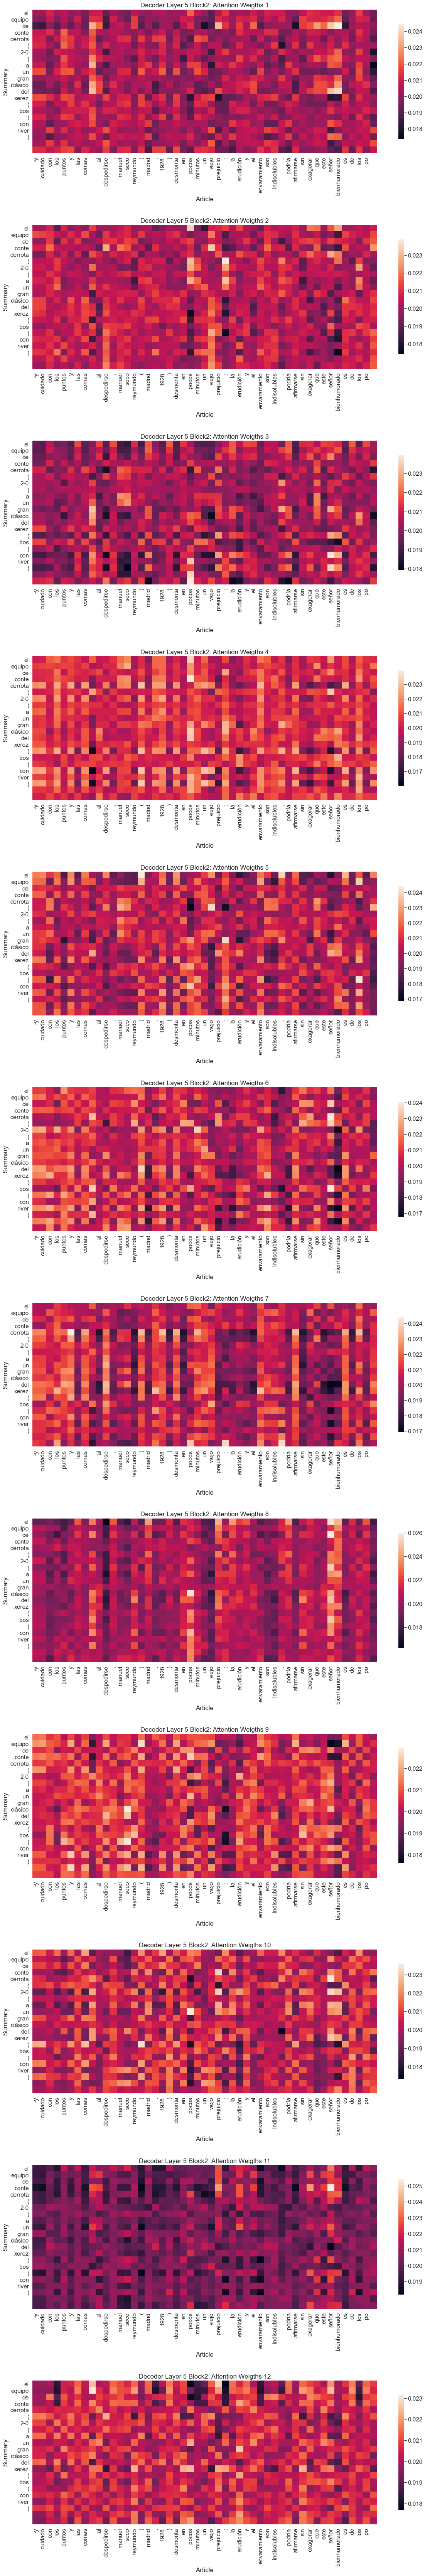

In [160]:
## Weigth Matrixes (Visualization)
## =============================================================================

n_rows = 12
n_cols = 1

sns.set(font_scale=1.4)
plt.figure(figsize=(n_cols * 20, n_rows*10))

for row in range(n_rows):
    plt.subplot(n_rows, n_cols, row + 1)
    
    weights = attention_weights['decoder_layer5_block2'].numpy()[0, row, :, :][1:,:]
    #cm = pd.DataFrame(weights)
    sns.heatmap(weights, 
                annot=False, 
                cbar_kws    = {"shrink": 0.8},
                xticklabels = tokens_input, 
                yticklabels = tokens_target[1:])
    plt.xlabel("Article")
    plt.ylabel("Summary")
    plt.title(f'Decoder Layer 5 Block2: Attention Weigths {row+1}');
    
plt.subplots_adjust(hspace=0.5)